In [17]:
import numpy as np
import torch
import os
import pickle
from model import GPT, GPTConfig
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
ALPHABET = [chr(i) for i in range(ord('a'), ord('z') + 1)]
SEP_BAR, SEP_Q = '|', '?'
batch_size = 64
block_size = 2048
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'

In [19]:
# load model checkpoint
checkpoint = torch.load('out/lr-1e-3/lr-1e-3_524M_ckpt.pt', map_location=device)
checkpoint_model_args = checkpoint['model_args']
n_layer=12
n_head=8
n_embd=256
bias=False
dropout=0.0
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout) # start with model_args from command line
# force these config attributes to be equal otherwise we can't even resume training
# the rest of the attributes (e.g. dropout) can stay as desired from command line
for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
    model_args[k] = checkpoint_model_args[k]
# create the model
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
state_dict = checkpoint['model']
# fix the keys of the state dictionary :(
# honestly no idea how checkpoints sometimes get this prefix, have to debug more
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
state_dict = None
iter_num = checkpoint['iter_num']
best_val_loss = checkpoint['best_val_loss']
total_tokens = checkpoint['total_tokens']
model.eval()

number of parameters: 9.45M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(28, 256)
    (wpe): Embedding(2048, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=256, out_features=768, bias=False)
          (c_proj): Linear(in_features=256, out_features=256, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=256, out_features=1024, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1024, out_features=256, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=256, out_features=28, bias=False)
)

In [20]:
dataset = 'openwebtext'
# poor man's data loader
data_dir = os.path.join('data', dataset)
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
stoi, itos = meta['stoi'], meta['itos']
vocab_size = meta['vocab_size'] 
print(f"Using vocab size of {vocab_size} (a-z + separators)")

# ---------------- helper: random mono‑alphabetic key --------
alpha_ids = np.array([stoi[c] for c in ALPHABET], dtype=np.uint8)
def random_key():
    perm = np.random.permutation(26)
    enc  = {alpha_ids[i]: alpha_ids[perm[i]] for i in range(26)}   # plain→cipher
    dec  = {v: k for k, v in enc.items()}                          # cipher→plain
    return enc, dec

def get_batch(split):
    mmap = np.memmap(os.path.join(data_dir, f'{split}.bin'),
                     dtype=np.uint8, mode='r')

    k_pairs   = 1024                              # desired number of pairs
    known_k   = k_pairs - 1                       # last one is the query
    prompt_sz = 2 * k_pairs                       # 2048 tokens
    assert prompt_sz == block_size, "block_size must be 2*k_pairs"

    X = torch.full((batch_size, block_size - 1), stoi['|'],  dtype=torch.long)
    Y = torch.full((batch_size, block_size - 1), -1,          dtype=torch.long)

    for b in range(batch_size):
        # ----- 1. grab k plaintext letters from corpus -------------------
        start = np.random.randint(0, len(mmap) - k_pairs - 1)
        plain = mmap[start:start + k_pairs].copy()          # np.uint8, shape (k_pairs,)

        # ----- 2. fresh random key for this sample -----------------------
        enc, _ = random_key()

        # ----- 3. build prompt ------------------------------------------
        buf, tgt = [], []
        for i, p in enumerate(plain):
            c = enc[p]
            if i < known_k:                                 # give answer
                buf.extend([c, p])
                tgt.extend([p, -1])
            else:                                           # query pair
                buf.extend([c])
                tgt.extend([p])

        X[b] = torch.from_numpy(np.asarray(buf,  np.uint8))
        Y[b] = torch.from_numpy(np.asarray(tgt, np.int64))

    if device_type == 'cuda':
        X, Y = X.pin_memory().to(device, non_blocking=True), \
               Y.pin_memory().to(device, non_blocking=True)
    else:
        X, Y = X.to(device), Y.to(device)
    return X, Y

eval_iters = 50
dtype = 'bfloat16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=device_type, dtype=ptdtype)
model.to(device)
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            X.to(device)
            Y.to(device)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

Using vocab size of 28 (a-z + separators)


In [5]:
l = estimate_loss()

In [6]:
print(l['train'], l['val'])

tensor(1.7698) tensor(1.7730)


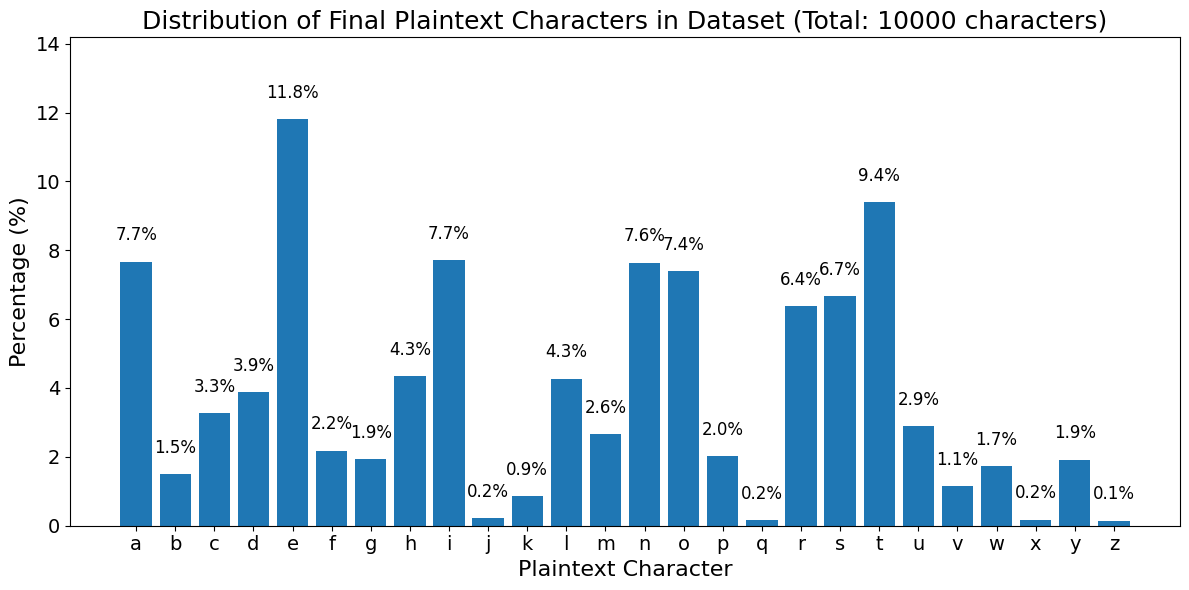

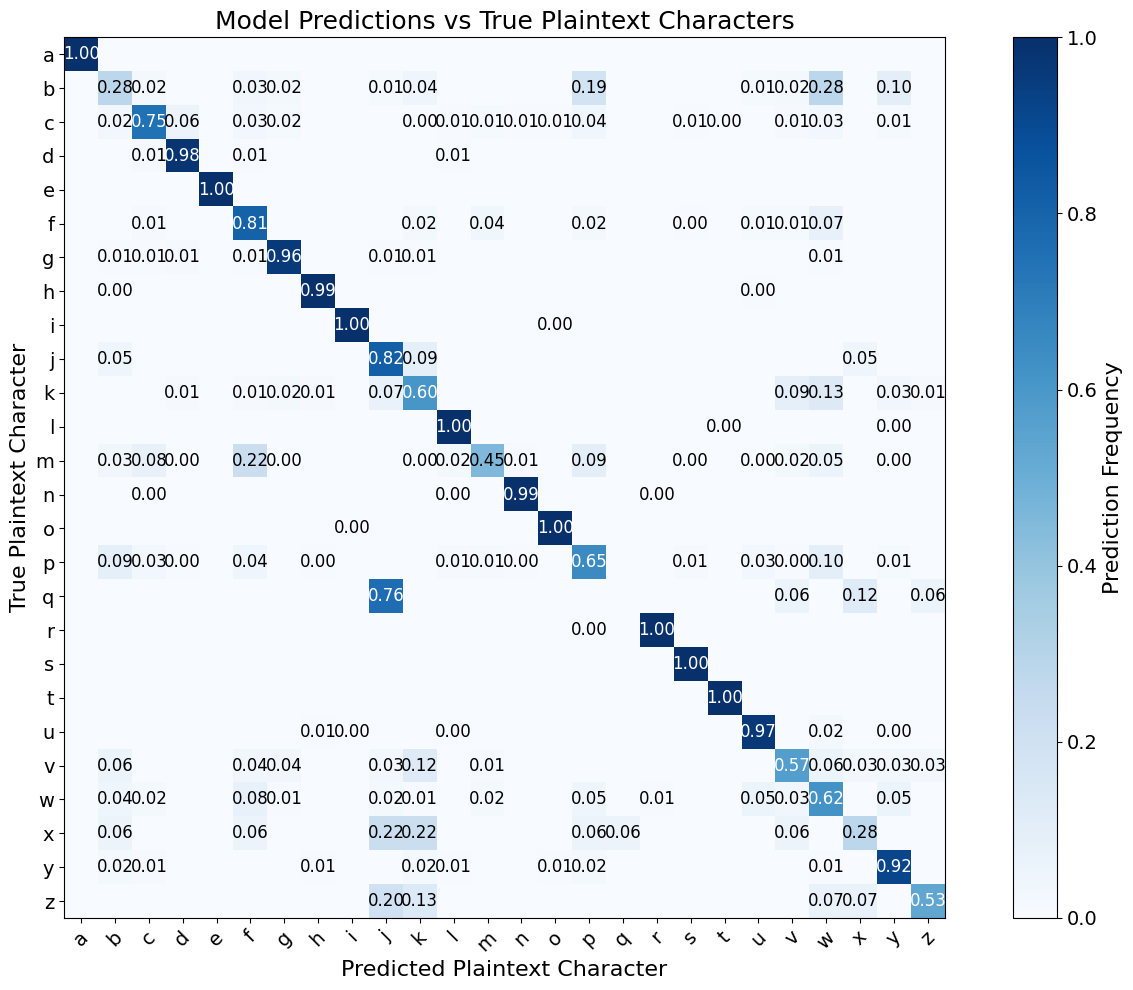

In [21]:
@torch.no_grad()
def visualize_samples(num_samples=5, split='val'):
    """
    Visualize samples from the dataset, showing the overall distribution of plaintext characters.
    
    Args:
        num_samples: Number of samples to process
        split: Dataset split to use ('train' or 'val')
    """
    model.eval()
    
    # For tracking the distribution of plaintext characters after query ciphertext
    query_cipher_to_plain = {}
    
    # For tracking model predictions vs true labels
    true_vs_pred = {}
    
    # Process samples to gather distribution data
    samples_processed = 0
    while samples_processed < num_samples:
        X, Y = get_batch(split)
        X = X.to(device)
        Y = Y.to(device)
        
        with ctx:
            logits, _ = model(X, Y)
        
        # For each batch item
        for i in range(X.shape[0]):
            # Find the last position in the sequence (where the model makes its prediction)
            seq_len = (X[i] != 0).sum().item()  # Count non-padding tokens
            if seq_len == 0:
                continue
                
            # The last position is where the prediction happens
            pred_pos = seq_len - 1
            
            # Get the true label
            true_label = Y[i, pred_pos].item()
            
            # Skip if true_label is -1 (padding)
            if true_label == -1:
                continue
            
            # Get model's prediction
            pred_label = logits[i, pred_pos].argmax(dim=-1).item()
            
            # Track true vs predicted
            true_char = itos[true_label]
            pred_char = itos[pred_label]
            
            if true_char not in true_vs_pred:
                true_vs_pred[true_char] = {}
            
            if pred_char not in true_vs_pred[true_char]:
                true_vs_pred[true_char][pred_char] = 0
                
            true_vs_pred[true_char][pred_char] += 1
            
            # Track the distribution of plaintext characters after query ciphertext
            # The last character in the sequence is the ciphertext we're querying about
            cipher_char = itos[X[i, pred_pos].item()]
            plain_char = itos[true_label]
            
            if cipher_char not in query_cipher_to_plain:
                query_cipher_to_plain[cipher_char] = {}
            
            if plain_char not in query_cipher_to_plain[cipher_char]:
                query_cipher_to_plain[cipher_char][plain_char] = 0
            
            query_cipher_to_plain[cipher_char][plain_char] += 1
            
            samples_processed += 1
            
            # Break if we have processed enough samples
            if samples_processed >= num_samples:
                break
    
    # Calculate the overall distribution of plaintext characters
    all_plain_counts = {}
    for cipher_dict in query_cipher_to_plain.values():
        for plain, count in cipher_dict.items():
            if plain not in all_plain_counts:
                all_plain_counts[plain] = 0
            all_plain_counts[plain] += count
    
    # Calculate total count for percentage calculation
    total_count = sum(all_plain_counts.values())
    
    # Calculate percentages
    all_plain_percentages = {plain: (count / total_count) * 100 for plain, count in all_plain_counts.items()}
    
    # First visualization: Overall distribution
    plt.figure(figsize=(12, 6))
    sorted_plains = sorted(all_plain_counts.keys())
    bars = plt.bar(sorted_plains, [all_plain_percentages[p] for p in sorted_plains])
    plt.title(f'Distribution of Final Plaintext Characters in Dataset (Total: {total_count} characters)', fontsize=18)
    plt.xlabel('Plaintext Character', fontsize=16)
    plt.ylabel('Percentage (%)', fontsize=16)
    plt.xticks(rotation=0, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Set a higher y-axis limit to make room for percentage labels
    max_percentage = max(all_plain_percentages.values())
    plt.ylim(0, max_percentage * 1.2)  # Add 20% more space above the highest bar
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Second visualization: Model predictions vs true labels
    plt.figure(figsize=(14, 10))
    
    # Get all unique characters
    all_chars = sorted(set(list(true_vs_pred.keys()) + 
                          [pred for true_dict in true_vs_pred.values() for pred in true_dict.keys()]))
    
    # Create confusion matrix
    confusion = np.zeros((len(all_chars), len(all_chars)))
    char_to_idx = {char: i for i, char in enumerate(all_chars)}
    
    for true_char, pred_dict in true_vs_pred.items():
        true_idx = char_to_idx[true_char]
        for pred_char, count in pred_dict.items():
            pred_idx = char_to_idx[pred_char]
            confusion[true_idx, pred_idx] = count
    
    # Normalize by row (true labels)
    row_sums = confusion.sum(axis=1, keepdims=True)
    confusion_norm = np.zeros_like(confusion)
    np.divide(confusion, row_sums, out=confusion_norm, where=row_sums!=0)
    
    # Plot heatmap
    plt.imshow(confusion_norm, cmap='Blues')
    cbar = plt.colorbar(label='Prediction Frequency')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Prediction Frequency', fontsize=16)
    plt.title('Model Predictions vs True Plaintext Characters', fontsize=18)
    plt.xlabel('Predicted Plaintext Character', fontsize=16)
    plt.ylabel('True Plaintext Character', fontsize=16)
    
    # Set ticks
    plt.xticks(np.arange(len(all_chars)), all_chars, fontsize=14)
    plt.yticks(np.arange(len(all_chars)), all_chars, fontsize=14)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add text annotations
    for i in range(len(all_chars)):
        for j in range(len(all_chars)):
            if confusion_norm[i, j] > 0:
                text_color = 'white' if confusion_norm[i, j] > 0.5 else 'black'
                plt.text(j, i, f'{confusion_norm[i, j]:.2f}', 
                        ha='center', va='center', color=text_color,
                        fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Visualize the overall distribution from the validation set
visualize_samples(num_samples=10000, split='val')


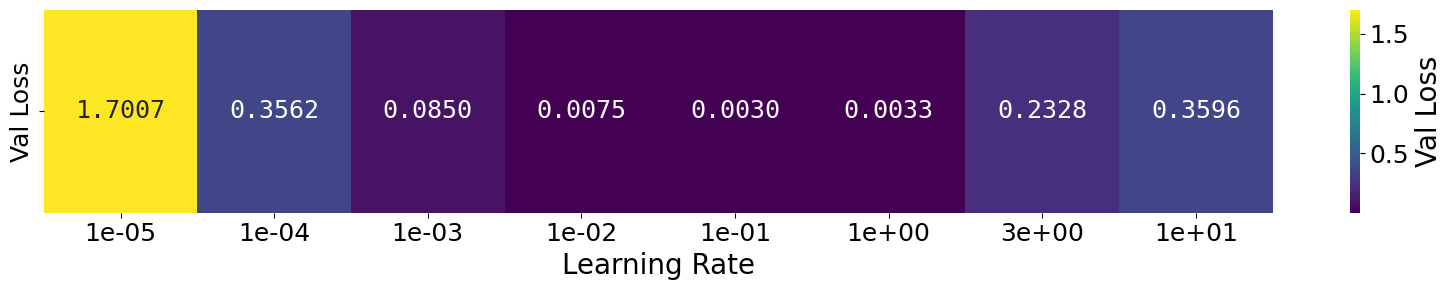

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Example data — replace with your actual values
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 3e0, 1e1]
validation_scores = [1.7007, 0.3562, 0.0850, 0.0075, 0.0030, 0.0033, 0.2328, 0.3596]

# Prepare heatmap data: 1 row, many columns
data = np.array([validation_scores])

# Convert LR to string for display
lr_labels = [f"{lr:.0e}" for lr in learning_rates]

# Set up the plot with wider figure
plt.figure(figsize=(16, 3))
ax = sns.heatmap(
    data,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    xticklabels=False,  # Disable default x-tick labels
    yticklabels=["Val Loss"],
    cbar_kws={"label": "Validation Loss"},
    annot_kws={"fontsize": 18, "fontfamily": "monospace"}
)

# Manually set centered x-tick labels
ax.set_xticks(np.arange(len(lr_labels)) + 0.5)  # Centered ticks
ax.set_xticklabels(lr_labels, fontsize=18, rotation=0)

# Label and title with larger font sizes
ax.set_xlabel("Learning Rate", fontsize=20)
ax.set_ylabel("")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# Increase font size of colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
cbar.set_label("Val Loss", fontsize=20)

plt.tight_layout()
plt.show()

In [10]:
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def extract_learning_rate(log_file_path):
    # Extract learning rate from filename (e.g., 'lr-1e-3.log' -> '1e-3')
    match = re.search(r'lr-([0-9e\-]+)', log_file_path)
    if match:
        return match.group(1)
    return "unknown"

def parse_log_file(log_file_path):
    with open(log_file_path, 'r') as f:
        log_data = f.read()
    
    # Extract learning rate from filename
    lr = extract_learning_rate(log_file_path)
    
    # Pattern to extract training loss from "iter X: loss Y"
    train_loss_pattern = re.compile(r"iter (\d+): loss ([\d.]+)")
    train_iters = []
    train_losses = []

    for match in train_loss_pattern.findall(log_data):
        iter_num = int(match[0])
        loss_val = float(match[1])
        train_iters.append(iter_num * 256)
        train_losses.append(loss_val)

    # Pattern to extract validation loss from "step X: train loss A, val loss B"
    val_loss_pattern = re.compile(r"step (\d+): train loss [\d.]+, val loss ([\d.]+)")
    val_steps = []
    val_losses = []

    for match in val_loss_pattern.findall(log_data):
        step_num = int(match[0])
        val_loss_val = float(match[1])
        val_steps.append(step_num * 256)
        val_losses.append(val_loss_val)
    
    return {
        'lr': lr,
        'train_iters': train_iters,
        'train_losses': train_losses,
        'val_steps': val_steps,
        'val_losses': val_losses
    }

def thousands_formatter(x, pos):
    if x >= 1000:
        return f'{x/1000:.0f}k'
    return f'{x:.0f}'

def plot_loss_curves(*log_file_paths):
    # Parse all log files
    all_data = [parse_log_file(path) for path in log_file_paths]
    
    # Colors for different learning rates
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    # Set larger font sizes
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 20,
        'axes.labelsize': 18,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16
    })
    
    # Plot training losses
    plt.figure(figsize=(12, 6))
    for i, data in enumerate(all_data):
        color = colors[i % len(colors)]
        plt.plot(data['train_iters'], data['train_losses'], 
                 label=f'LR={data["lr"]}', color=color, linewidth=2.5)
    
    plt.xlabel('# Keys', fontsize=18, fontweight='bold')
    plt.ylabel('Train Loss', fontsize=18, fontweight='bold')
    plt.title('Training Loss Curves', fontsize=20, fontweight='bold')
    plt.grid(True)
    plt.legend(fontsize=16, frameon=True, facecolor='white', edgecolor='black')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

    # Plot validation losses
    plt.figure(figsize=(12, 6))
    for i, data in enumerate(all_data):
        if data['val_steps']:  # Only plot if validation data exists
            color = colors[i % len(colors)]
            plt.plot(data['val_steps'], data['val_losses'], 
                     label=f'LR={data["lr"]}', color=color, marker='o', markersize=10, linewidth=2.5)
    
    plt.xlabel('# Keys', fontsize=18, fontweight='bold')
    plt.ylabel('Val Loss', fontsize=18, fontweight='bold')
    plt.title('Validation Loss Curves', fontsize=20, fontweight='bold')
    plt.grid(True)
    plt.legend(fontsize=16, frameon=True, facecolor='white', edgecolor='black')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()

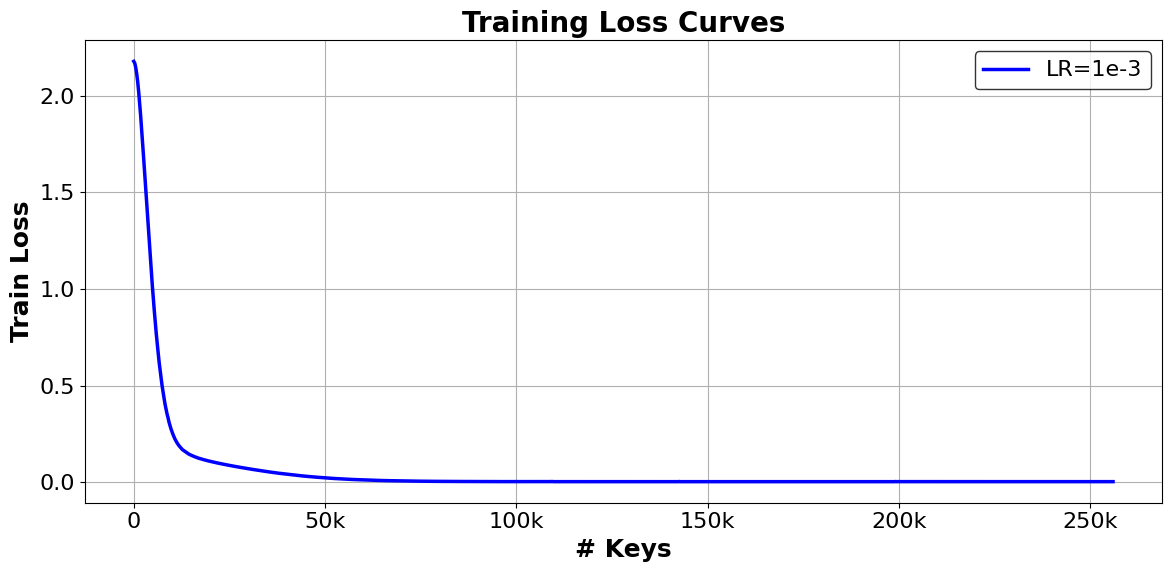

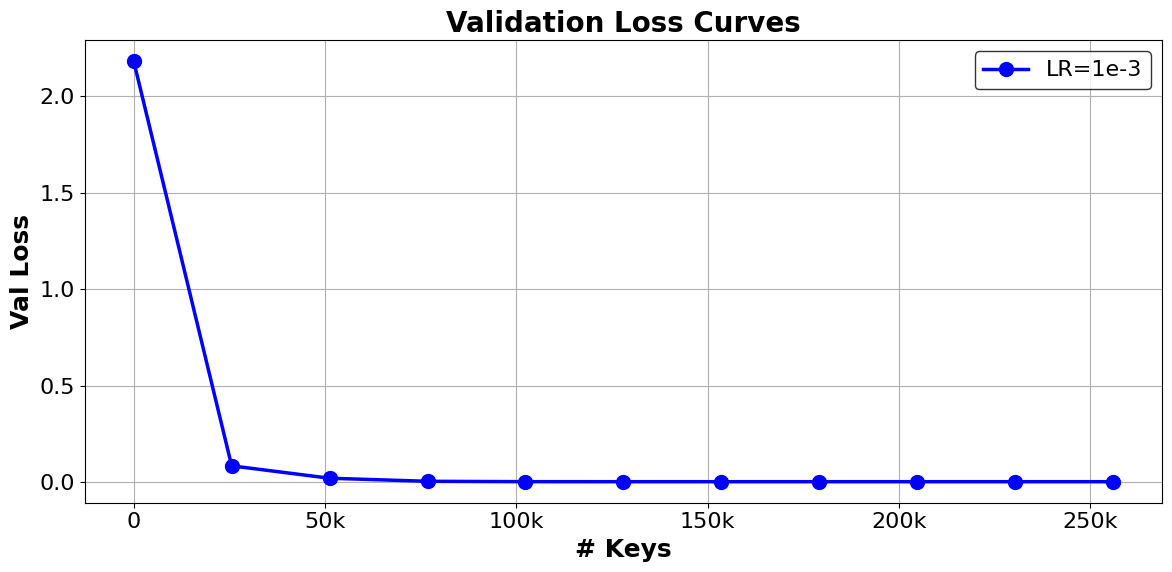

In [12]:
plot_loss_curves('logs/lr-1e-3.log')

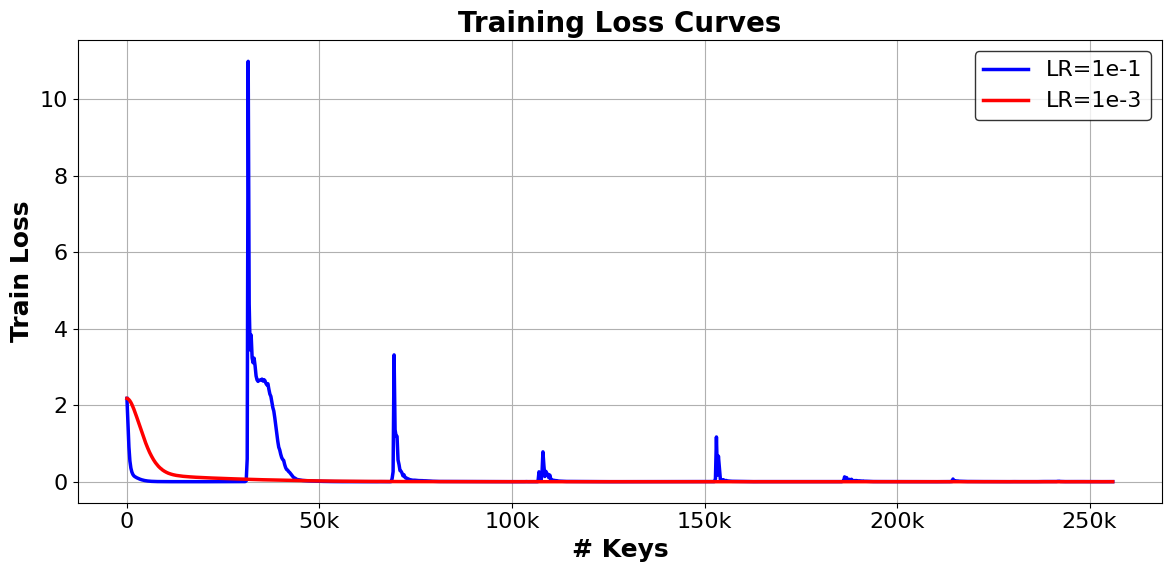

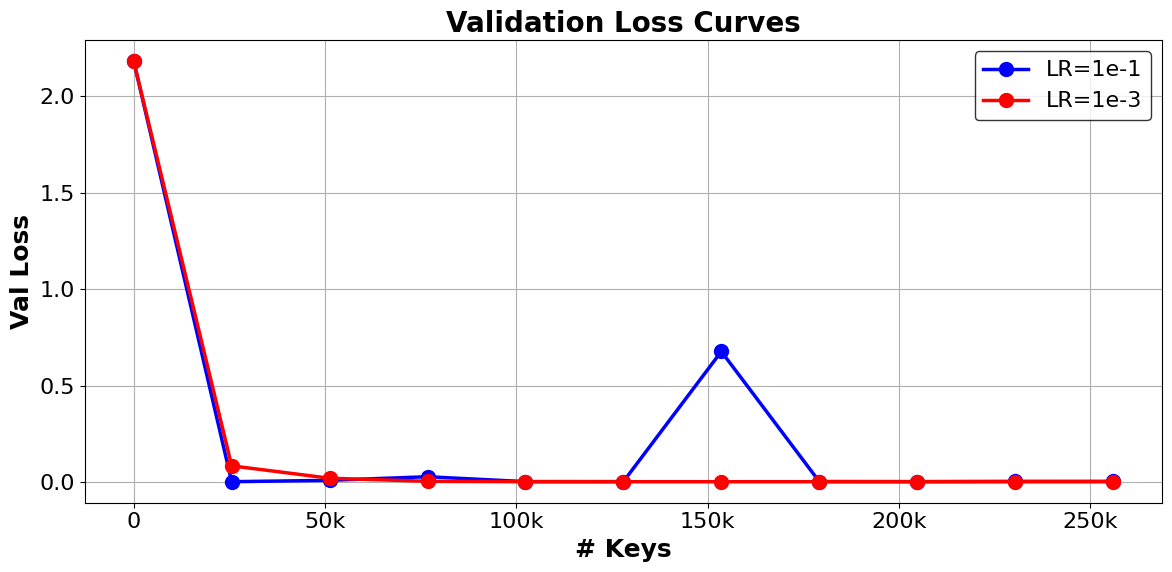

In [11]:
plot_loss_curves('logs/lr-1e-1.log', 'logs/lr-1e-3.log')

In [26]:
@torch.no_grad()
def model_infer(input_seq):
    """
    Runs inference on a single input sequence and returns the model's output sequence.

    Args:
        input_seq (str): The input sequence (e.g., ciphertext or prompt).

    Returns:
        output_seq (str): The predicted output sequence.
    """
    model.eval()

    # Convert the input sequence to tensor
    input_indices = torch.tensor([stoi[c] for c in input_seq], dtype=torch.long).unsqueeze(0).to(device)

    # Create a dummy Y for conditioning if required (same shape as input)
    dummy_Y = torch.zeros_like(input_indices).to(device)

    # Forward pass
    logits, _ = model(input_indices, dummy_Y)
    print(logits.shape)

    # Take the most likely token at each position
    predicted_indices = logits.argmax(dim=-1).squeeze(0)  # shape: (sequence length,)

    # Convert back to string
    output_seq = ''.join([itos[idx.item()] for idx in predicted_indices])

    return output_seq

In [47]:
alpha_ids = np.array([stoi[c] for c in ALPHABET], dtype=np.uint8)
def random_key():
    perm = np.random.permutation(26)
    enc  = {alpha_ids[i]: alpha_ids[perm[i]] for i in range(26)}   # plain→cipher
    dec  = {v: k for k, v in enc.items()}                          # cipher→plain
    return enc, dec

In [49]:
enc

{np.uint8(0): np.uint8(19),
 np.uint8(1): np.uint8(5),
 np.uint8(2): np.uint8(17),
 np.uint8(3): np.uint8(20),
 np.uint8(4): np.uint8(24),
 np.uint8(5): np.uint8(3),
 np.uint8(6): np.uint8(6),
 np.uint8(7): np.uint8(14),
 np.uint8(8): np.uint8(21),
 np.uint8(9): np.uint8(11),
 np.uint8(10): np.uint8(23),
 np.uint8(11): np.uint8(10),
 np.uint8(12): np.uint8(13),
 np.uint8(13): np.uint8(9),
 np.uint8(14): np.uint8(18),
 np.uint8(15): np.uint8(25),
 np.uint8(16): np.uint8(2),
 np.uint8(17): np.uint8(22),
 np.uint8(18): np.uint8(1),
 np.uint8(19): np.uint8(4),
 np.uint8(20): np.uint8(15),
 np.uint8(21): np.uint8(16),
 np.uint8(22): np.uint8(0),
 np.uint8(23): np.uint8(8),
 np.uint8(24): np.uint8(7),
 np.uint8(25): np.uint8(12)}

In [100]:
# Sample a random sentence from the validation set
data_dir = os.path.join('data', dataset)
val_mmap = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint8, mode='r')

# Get a random segment of text (let's say 30 characters)
sample_length = 30
start_idx = np.random.randint(0, len(val_mmap) - sample_length)
plain_ids = val_mmap[start_idx:start_idx + sample_length].copy()

# Convert to plaintext
plain = ''.join([itos[idx] for idx in plain_ids])
print(f"Plaintext: {plain}")

# Generate a random encryption key
enc, dec = random_key()

# Encrypt the plaintext
cipher_ids = np.array([enc[p] for p in plain_ids], dtype=np.uint8)
cipher = ''.join([itos[idx] for idx in cipher_ids])
print(f"Ciphertext: {cipher}")

# Create the prompt for the model (all but last character pairs)
known_k = len(plain_ids) - 1
buf = []
for i in range(known_k):
    buf.extend([cipher_ids[i], plain_ids[i]])
buf.append(cipher_ids[known_k])  # Add the last cipher character as query

# Convert to string for visualization
prompt_str = ''.join([itos[idx] for idx in buf])
print(f"Model prompt: {prompt_str}")

# Prepare input for model_infer
input_seq = prompt_str

# Get the ground truth (the last plaintext character)
ground_truth = itos[plain_ids[known_k]]
print(f"Ground truth (last character): {ground_truth}")

# The model will predict this in the next cell
print(f"The model will predict the decryption of '{itos[cipher_ids[known_k]]}' → ?")

Plaintext: ogetherbuttheywereseparatedreu
Ciphertext: nriewijxoeewiflijihidyjyeiajio
Model prompt: norgieetwhiejrxbouetetwhiefylwiejriehsiedpyajryaetieadjrieo
Ground truth (last character): u
The model will predict the decryption of 'o' → ?


In [101]:
output = model_infer(input_seq)
print(output[-1])

torch.Size([1, 59, 28])
u
